In [1]:
import os 
from pathlib import Path
import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
import seaborn as sns

sns.set_style('whitegrid')


# About

__Author:__ Pat McCornack

__Date:__ December 2024

__Description:__  
This notebook preprocesses the data and does basic qc checks. This includes subsetting the variables, renaming the variables to a standard format, and taking the action specified in the finding summary. 

__Findings Summary:__  
There's a number of observations with missing timestamps. The entire record is missing for each of these. There's a small number of observations missing for most variables. All missing observations were dropped. Leaf wetness is available, but was found to potentially be unreliable and is not included in this analysis. The same applies to solar radiation. Relative humidity values that were above 100% were set to 100%. 

__Outputs:__  
Cleaned data is output to `./data/02-clean/sci-sauc-clean-2003-2008.csv`. 

In [65]:
def agg_time(df):
    """
    Create datetime stamp using separate Month, Day, Hour, Miunute columns. 

    Parameters
    ----------
    df : pandas.DataFrame
        DataFrame to create datetime column for. 

    Returns
    -------
    pandas.DataFrame
        Dataframe with the new 'time (PST)' column, sorted by the 'time (PST)' column. 

    """
    times = []
    for index, row in df.iterrows():
        times.append(f"{str(row['Year']).split('.')[0]}-{str(row['Month']).split('.')[0]}-{str(row['Day']).split('.')[0]} {str(row['Hour']).split('.')[0]}:{str(row['Minute']).split('.')[0]}:00")

    df['time (PST)'] = pd.to_datetime(times)
    df = df.sort_values(by='time (PST)', ascending=True)

    return df

def subset_summer(df):
    """
    Subset data to summer months (May-Sept). This is done because summer is the ecologically relevant period for fog. 

    Parameters
    ----------
    df : pandas.DataFrame
        Dataframe to subset.
    
    Returns
    -------
    pandas.DataFrame
        Dataframe subset to May 01 - September 30. 
    """
    df.set_index('time (PST)', inplace=True)
    df = df[df.index.month.isin([5,6,7,8,9])]
    df.reset_index(inplace=True)

    return df

## Data QC 

In [ ]:
# Specify parameters
# Options
process_time = True  # Does the data have a 'time (PST)' column already, or separate columns for 'month', 'day', etc. 

In [ ]:
#### Specify Arguments ###
fname1 = 'sci-sauc-2003-2010.csv'
fname2 = 'sci-sauc-june-oct-2011.csv'

root_dir = Path().resolve().parents[1]
data_dir = root_dir / 'data'
src_fpath1 = data_dir / '01-raw' / 'met-station' / fname1
src_fpath2 = data_dir / '01-raw' / 'met-station' / fname2

outfpath = data_dir / '02-clean' / f'{str(fname1).split('.')[0]}-clean.csv'


PosixPath('/Users/patmccornack/Documents/ucsb_fog_project/_repositories/sci-fog-analysis')

In [67]:
#### Specify Arguments ###
# Source data paths
src_dir = './data/01-raw/met-station/still-lab/'
src_fname = 'sci-sauc-2003-2008.csv'
src_fpath = os.path.join(src_dir, src_fname)

# Out paths
outdir = './data/02-clean/'
out_fname = 'sci-sauc-clean-2003-2008.csv'
out_fname_summer = 'sci-sauc-summer-clean-2003-2008.csv'  # If subset to summer months

# Define variables
var_dict = {
    'time (PST)' : 'time (PST)',
    'fog' :'Fog',
    'air temperature (C)' : 'Temp',
    'relative humidity (%)' : 'RH',
    'wind speed (m/s)' : 'WS_MS_S_WVT',  # Has same values as 'WindSpd', but no missing observations
    'wind gust (m/s)' : 'WS_MS_MAX',
    'wind direction (deg)' : 'WindDir',
    'rain (mm)' : 'Rain',  # Unsure about units
    # 'solar radiation (kwm2)' :'Pyran_Avg',  # Data is suspect - 0s during day, nonzeros at night - plus missing many values
    # 'leaf wetness (mv)' : 'LeafWet'  # Missing many values, leaving out. Unsure if values coded as 99999 are NA
}

# Fog tip value
fog_tip_v = 4.714



In [68]:
#### Read in and prepare data ####
df = pd.read_csv(src_fpath)

# Create single datetime column
df = agg_time(df)

# Subset and rename columns
df = df[list(var_dict.values())]
df.columns = list(var_dict.keys())

# Create fog tip var
df['fog tips'] = df['fog'] / fog_tip_v
    
# Subset to summer months
if summer_subset == True:
    df = subset_summer(df)

df.head(3)

,time (PST),fog,air temperature (C),relative humidity (%),wind speed (m/s),wind gust (m/s),wind direction (deg),rain (mm),fog tips
0,2003-12-19 16:00:00,0.0,15.53,27.54,0.63,0.95,92.21,0.0,0.0
1,2003-12-19 17:00:00,0.0,15.22,27.05,1.40,3.96,99.26,0.0,0.0
2,2003-12-19 18:00:00,0.0,14.68,32.86,2.07,3.75,140.33,0.0,0.0


### Missing Values
Observations:
1. ~~Leaf wetness is missing around a quarter of values~~ - no longer included in set of variables. 
2. ~~Solar radiation is missing around a quarter of observations.~~ - lo longer included in set of variables.
3. There are missing timestamps, which are likely completely empty observations - Verified by inspecting csv. 
4. There's a small number of missing observations for most variables. 

Actions:
1. Drop missing observations


In [69]:
df.dropna(subset='time (PST)', inplace=True)

In [70]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 199751 entries, 0 to 40005
Data columns (total 9 columns):
 #   Column                 Non-Null Count   Dtype         
---  ------                 --------------   -----         
 0   time (PST)             199751 non-null  datetime64[ns]
 1   fog                    198566 non-null  float64       
 2   air temperature (C)    198570 non-null  float64       
 3   relative humidity (%)  198570 non-null  float64       
 4   wind speed (m/s)       198566 non-null  float64       
 5   wind gust (m/s)        198565 non-null  float64       
 6   wind direction (deg)   198566 non-null  float64       
 7   rain (mm)              198566 non-null  float64       
 8   fog tips               198566 non-null  float64       
dtypes: datetime64[ns](1), float64(8)
memory usage: 15.2 MB


In [71]:
# When are values missing? 
missing = df.loc[df.isna().any(axis=1)]
pd.to_datetime(missing['time (PST)']).describe()

count                             1186
mean     2004-10-21 13:58:05.413153408
min                2004-10-14 11:30:00
25%                2004-10-17 14:03:45
50%                2004-10-20 16:07:30
75%                2004-10-23 18:11:15
max                2007-07-14 12:45:00
Name: time (PST), dtype: object

In [72]:
# Drop Missing
df = df.dropna()

### Univariate Distributions

Check boxplots of each variable to assess data quality.

Observations:
1. Relative humidity is typically high at the site. 
2. Wind typically comes from the northwest, but has a higher spread than pozo.  
3. Most fog observations are 0 - this skews the distribution.
4. There are RH values above 100. 
5. ~~It looks like the pyranometer values are probably in w/m2~~ Not currently using pyranometer. 

Actions
1. Set observations where RH is above 100 to 100. 
2. Check the observations where RH is 0. 
3. Look closer at the distribution of the fog values.
4. ~~Correct solar radiation to represent kw/m2.~~ Not currently using pyranometer values. 

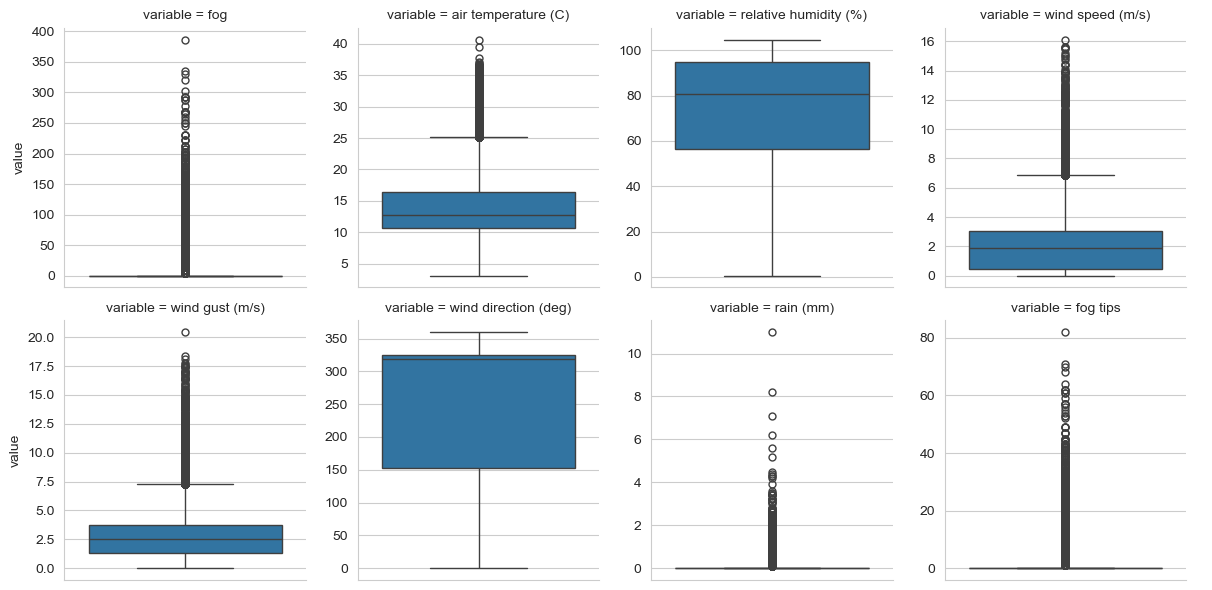

In [73]:
#### Quick plot of distributions ####
# Create long form data
value_col = df.columns.drop(['time (PST)']).tolist()
df_long = pd.melt(df, id_vars=['time (PST)'], value_vars=value_col)

# Plot boxplots
sns.catplot(data=df_long, kind='box', col='variable', y='value',
            sharey=False, height=3, col_wrap=4)
plt.show()


In [74]:
#### Check the actual values ####
df.describe()

,time (PST),fog,air temperature (C),relative humidity (%),wind speed (m/s),wind gust (m/s),wind direction (deg),rain (mm),fog tips
count,198565,198565.000000,198565.000000,198565.000000,198565.000000,198565.000000,198565.000000,198565.000000,198565.000000
mean,2007-02-19 20:33:04.627703296,0.969247,14.001261,70.533730,1.962423,2.560273,244.381957,0.006952,0.205610
min,2003-12-19 16:00:00,0.000000,3.100000,0.539000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,2005-08-21 17:00:00,0.000000,10.630000,56.320000,0.480000,1.300000,152.400000,0.000000,0.000000
50%,2007-01-20 19:15:00,0.000000,12.790000,80.900000,1.892000,2.500000,319.430000,0.000000,0.000000
75%,2008-09-19 13:00:00,0.000000,16.440000,94.700000,3.040000,3.700000,325.500000,0.000000,0.000000
max,2010-02-18 15:15:00,386.550000,40.670000,104.700000,16.120000,20.450000,359.900000,11.000000,82.000424
std,NaN,7.674557,4.815383,29.321446,1.583593,1.791054,119.690907,0.095072,1.628035


### Set RH > 100 to 100

In [75]:
df['relative humidity (%)'] = df['relative humidity (%)'].apply(lambda x: 100 if x > 100 else x)

### ~~Scale solar radiation~~
~~Solar radiation is measured in w/m2 based on the data, scale it to be kw/m2.~~

In [76]:
#df['solar radiation (kwm2)'] = df['solar radiation (kwm2)'] / 1000

### Fog Check
Given the focus of further analysis on fog at the site, further check the distribution of fog.

Observations:
1. Nothing of note, the distribution is as expected. 


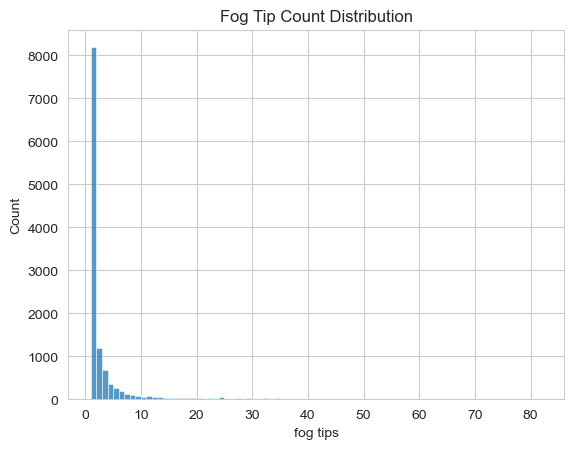

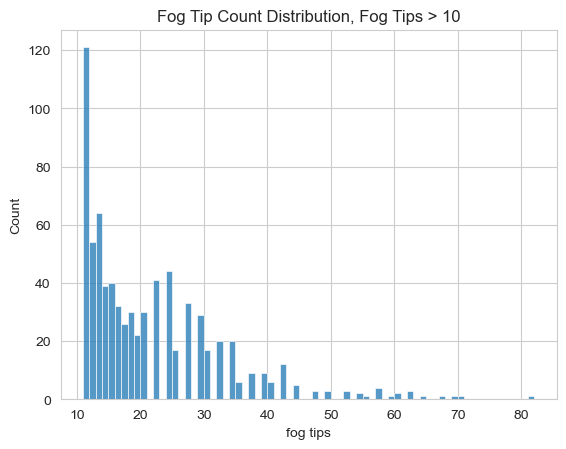

In [77]:
#### Check Distribution of Fog Values ####
sns.histplot(df['fog tips'].loc[df['fog tips']>0],
             binwidth=1)
plt.title('Fog Tip Count Distribution')
plt.show()

# Check right tail of distribution
sns.histplot(df['fog tips'].loc[df['fog tips']>10],
             binwidth=1)
plt.title('Fog Tip Count Distribution, Fog Tips > 10')
plt.show()

### Save out cleaned data

In [78]:
#### Save out cleaned data ####
if summer_subset == True:
    out_fpath = os.path.join(outdir, out_fname_summer)
    df.to_csv(out_fpath)

else:
    out_fpath = os.path.join(outdir, out_fname)
    df.to_csv(out_fpath)

print(out_fpath)

./data/02-clean/sci-sauc-summer-clean-2003-2008.csv
